In [1]:
import uproot
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# import hist
import scipy.optimize as opt
import sys

In [2]:
sys.path.append('/project/rpp-blairt2k/jgao/WatChMaL')
import analysis.event_utils as ev

# Set up

In [3]:
particles = ("e-", "mu-", "pi0")
particle_index = {"e-": 1, "mu-": 2, "pi0": 3}
particle_mass = {"e-": 0.511, "mu-": 105.7, "pi0": 135.0}

## Read files

### Truth (hdf5) file and veto calculations

In [4]:
# get indices of test events
idxs_path = '/scratch/jgao/data/HKHybrid/idxs.npz'
idxs = np.load(idxs_path, allow_pickle=True)
test_idxs  = idxs['test_idxs']

In [5]:
# open h5 file and get data for test events
data_path = "/scratch/jgao/data/HKHybrid/all.hdf5"
h5_file = h5py.File(data_path, "r")
h5_angles     = np.array(h5_file['angles'])[test_idxs].squeeze()
h5_energies   = np.array(h5_file['energies'])[test_idxs].squeeze()
h5_positions  = np.array(h5_file['positions'])[test_idxs].squeeze()
h5_labels     = np.array(h5_file['labels'])[test_idxs].squeeze()
h5_root_files = np.array(h5_file['root_files'])[test_idxs].squeeze()
h5_event_ids  = np.array(h5_file['event_ids'])[test_idxs].squeeze()
h5_vetos      = np.array(h5_file['veto'])[test_idxs].squeeze()

In [6]:
# create dictionaries to hold truth and veto info for fq cuts later
veto = {}
true_dwall = {}
true_mom = {}

towall = ev.towall(h5_positions, h5_angles, tank_half_height=3287, tank_radius=3240, tank_axis=2)
dwall = ev.dwall(h5_positions, tank_half_height=3287, tank_radius=3240, tank_axis=2)
momentum = ev.momentum(h5_energies, h5_labels)

# fill true momentum and veto dict
for p in particles:
    indicies_in_h5 = np.where(h5_labels==particle_index[p])
    veto[p]        = h5_vetos[indicies_in_h5]
    true_dwall[p]  = dwall[indicies_in_h5]
    true_mom[p]    = momentum[indicies_in_h5]
#     print("number of indices for %s: %i" %(p, len(indicies_in_h5[0])))
#     print("length of veto array: %i, length of dwall array: %i, length of mom array: %i" 
#           %(len(veto[p]), len(true_dwall[p]),len(veto[p])))


### fiTQun files


In [7]:
true_momentum = {}
reco_e_mom = {}
e_nll = {}
mu_nll = {}
pi0_nll = {}
emu_nll = {}
epi0_nll = {}
pi0mass = {}
t0 = 950
fq_path = "/project/rpp-blairt2k/machine_learning/data/HKHybrid/fiTQun/"
for p in particles:
    fq = uproot.open(fq_path+f"HKHybrid_{p}_3000x400.fiTQun.root")['fiTQun']
    flag_e = np.array(fq['fq1rpcflg'].array()[:,0,particle_index['e-']])
    flag_mu = np.array(fq['fq1rpcflg'].array()[:,0,particle_index['mu-']])
    reco_t0_e = np.array(fq['fq1rt0'].array()[:,0,particle_index['e-']])
    reco_t0_mu = np.array(fq['fq1rt0'].array()[:,0,particle_index['mu-']])
    cut = ((flag_e==0) & (flag_mu==0) & (reco_t0_e<t0+100) & (reco_t0_mu<t0+100) &
           (veto[p]==0) & (true_dwall[p]>100) & (true_mom[p]>100) & (true_mom[p]<1100)).astype(bool)
    print(f"{p} : {np.sum(cut)} events selected out of {len(cut)}")
    e_nll[p] = np.array(fq['fq1rnll'].array()[cut,0,1])
    mu_nll[p] = np.array(fq['fq1rnll'].array()[cut,0,2])
    pi0_nll[p] = np.array(fq['fqpi0nll'].array()[cut,0])
    true_momentum[p] = true_mom[p][cut]
    reco_e_mom[p] = np.array(fq['fq1rmom'].array()[cut,0,1])
    emu_nll[p] = e_nll[p]-mu_nll[p]
    epi0_nll[p] = e_nll[p]-pi0_nll[p]
    pi0mass[p] = np.array(fq['fqpi0mass'].array()[cut,0])

e- : 798791 events selected out of 1200000
mu- : 844311 events selected out of 1200000
pi0 : 845610 events selected out of 1200000


In [8]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 28}
matplotlib.rc('font', **font)

In [9]:
def plot_binned_res(res_binned, bin_centres, particle, x_err, y_err,
                    x_label, y_label, filename=None):
    fig, ax = plt.subplots(figsize=(20,15))
    res = np.array(res_binned[particle])
    ax.errorbar(bin_centres[1:], res[1:], yerr=y_err[particle][1:], xerr=x_err[1:],
                fmt='-o', capsize=5, lw=2)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.ticklabel_format(useOffset=False)
    #ax.set_ylim(bottom=0)
    #ax.legend()
    fig.tight_layout()
    if filename is not None:
        fig.savefig(filename+".pdf")
    return fig, ax

# PID

## e vs mu with 0.5% mu mis-ID

In [20]:
cut_bin_low = 100
cut_bin_high = 1100
cut_bin_width = 50
cut_bin_lows = np.arange(cut_bin_low, cut_bin_high, cut_bin_width)

# emu_cut_mom_cuts = {p: [(reco_e_mom[p] > l) & (reco_e_mom[p] <= l+cut_bin_width) for l in cut_bin_lows]
#                        for p in ('e-', 'mu-')}
emu_cut_mom_cuts = {p: [(true_momentum[p] > l) & (true_momentum[p] <= l+cut_bin_width) for l in cut_bin_lows]
                   for p in ('e-', 'mu-')}

emu_cut_values = [np.quantile(emu_nll['mu-'][c], 0.005) for c in emu_cut_mom_cuts['mu-']]

emu_cuts = {p: np.zeros_like(emu_nll[p]).astype(bool) for p in ('e-', 'mu-')}
for p in ('e-', 'mu-'):
    for cv, c in zip(emu_cut_values, emu_cut_mom_cuts[p]):
        emu_cuts[p][c] = emu_nll[p][c] < cv

In [21]:
plot_bin_low = 200
plot_bin_high = 1100
plot_bin_width = 50
plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

emu_eff_binned = {}
emu_eff_binned_err = {}
for p in ('e-', 'mu-'):
    plot_mom_cuts = [(true_momentum[p] > l) & (true_momentum[p] <= l+plot_bin_width)
                     for l in plot_bin_lows]
    counts = np.sum(plot_mom_cuts, axis=1)
    emu_eff_binned[p] = np.array([np.mean(emu_cuts[p][c]) for c in plot_mom_cuts])
    emu_eff_binned_err[p] = np.sqrt(emu_eff_binned[p]*(1-emu_eff_binned[p])/counts)

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


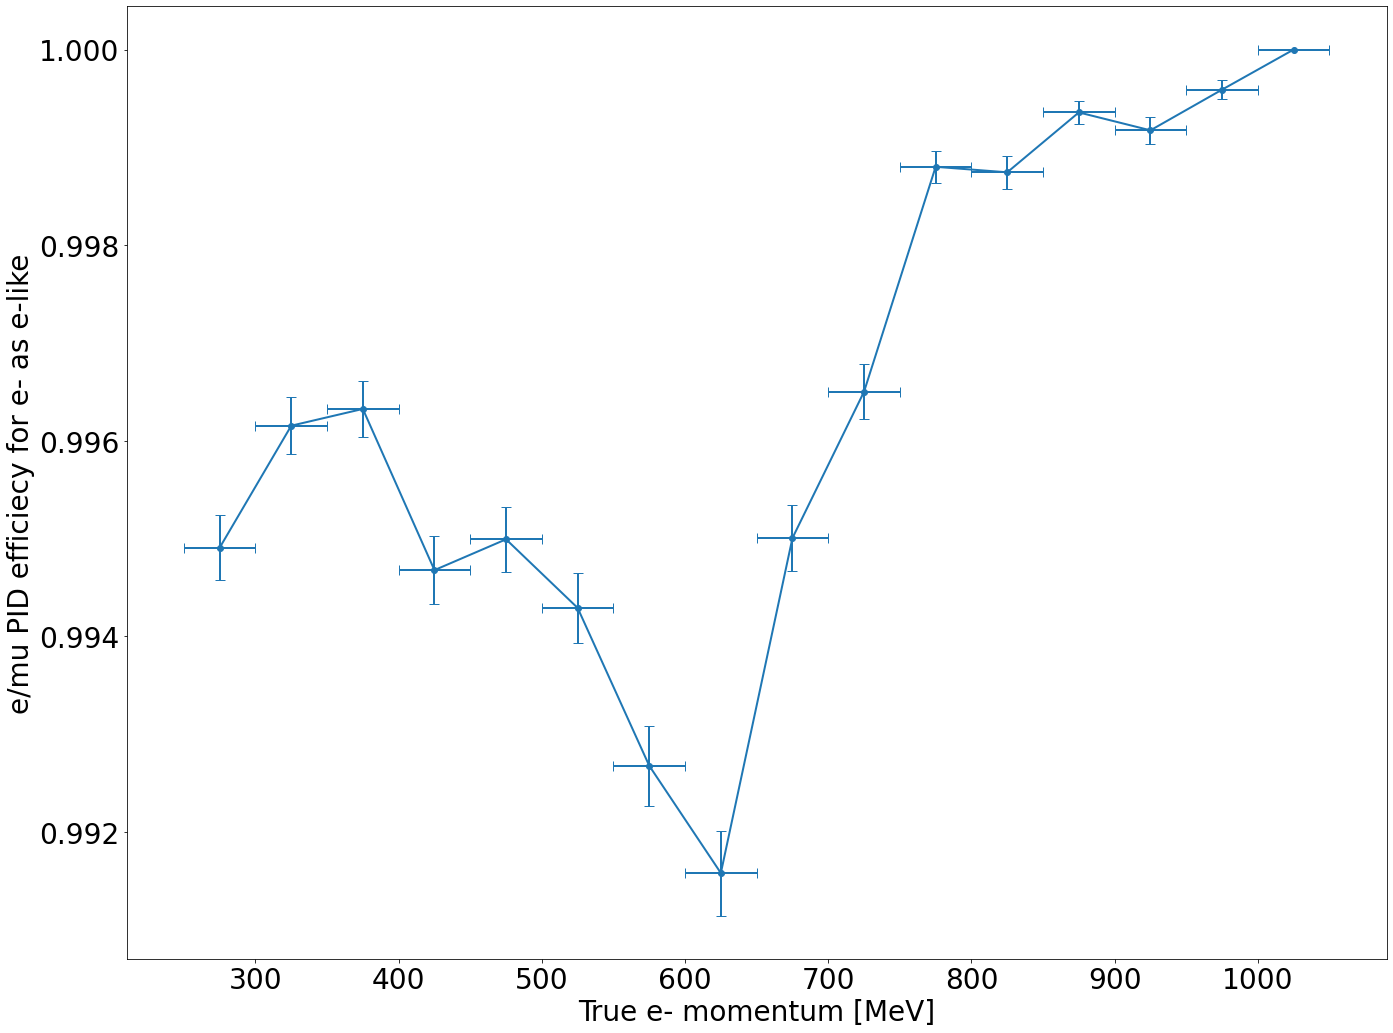

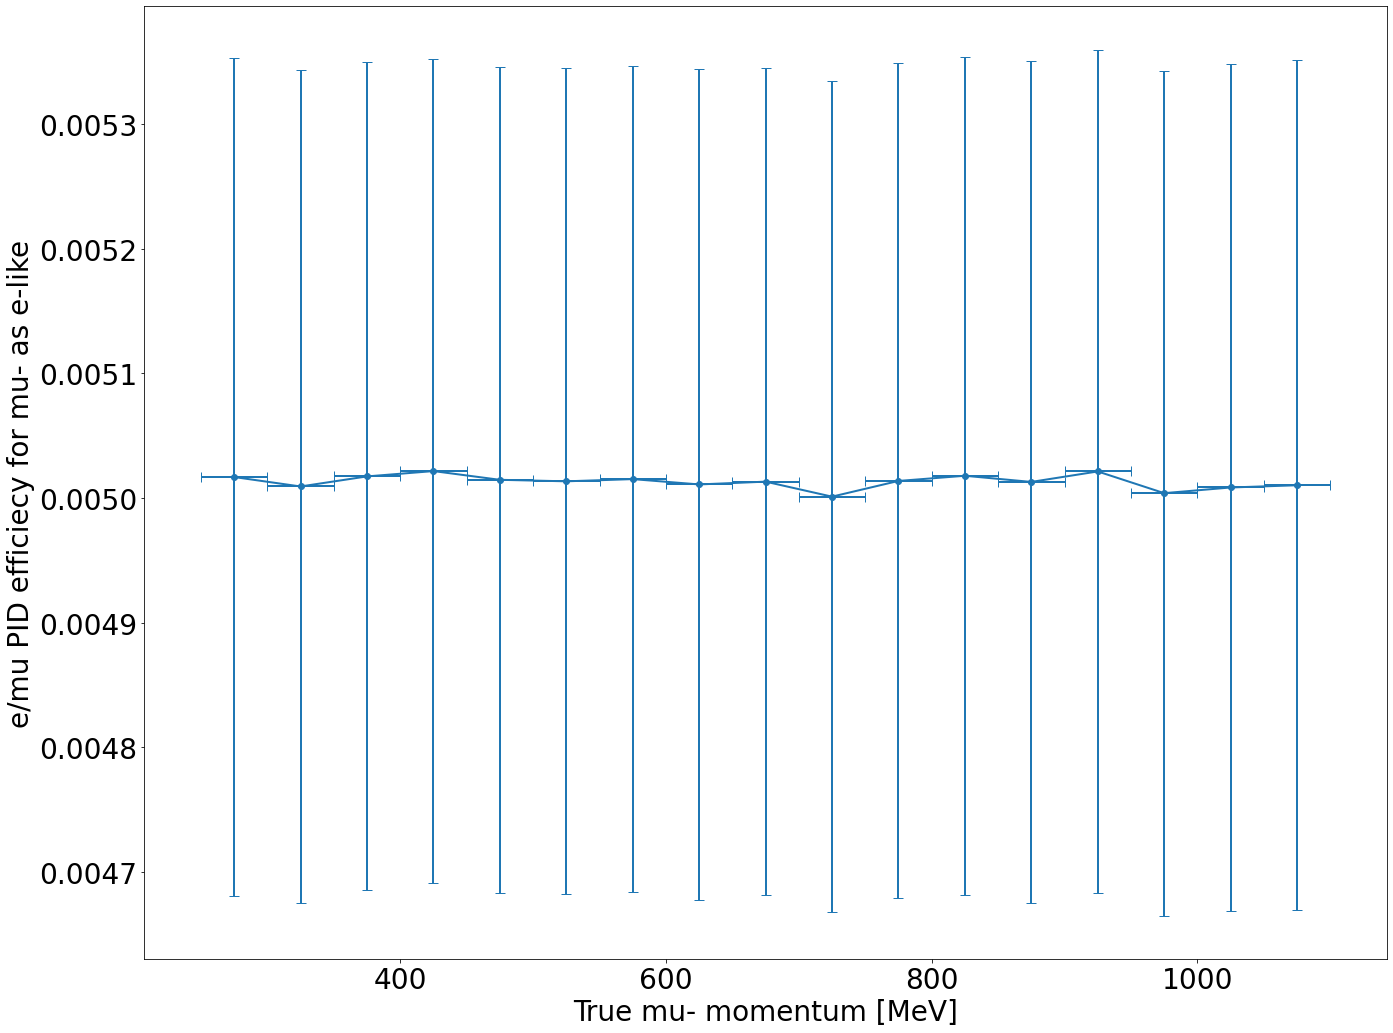

In [22]:
for p in ('e-', 'mu-'):
    plot_binned_res(emu_eff_binned, plot_bin_centres, p, plot_bin_halfwidths, emu_eff_binned_err,
                    f"True {p} momentum [MeV]", f"e/mu PID efficiecy for {p} as e-like",
                    filename=None)

## e vs pi0 with 5% pi0 mis-ID

In [10]:
cut_bin_low = 100
cut_bin_high = 1100
cut_bin_width = 50
cut_bin_lows = np.arange(cut_bin_low, cut_bin_high, cut_bin_width)

def epi0_get_intercept(cut_gradient, epi0_nll, pi0mass, pi0_misid=0.05):
    discriminator = epi0_nll - cut_gradient*pi0mass
    cut_intercept = np.quantile(discriminator, pi0_misid)
    return cut_intercept

def epi0_e_misid(cut_gradient, e_epi0_nll, e_pi0mass, pi0_epi0_nll, pi0_pi0mass, pi0_misid=0.05):
    cut_intercept = epi0_get_intercept(cut_gradient, pi0_epi0_nll, pi0_pi0mass, pi0_misid)
    e_misid = np.mean(e_epi0_nll - cut_gradient*e_pi0mass >= cut_intercept)
    return e_misid

epi0_cuts = {}
epi0_cut_mom_cuts = {}
epi0_eff_binned = {p:{} for p in ('e-', 'pi0')}
epi0_eff_binned_err = {p:{} for p in ('e-', 'pi0')}
epi0_cut_mom_cuts = {p: [(true_momentum[p] > l) & (true_momentum[p] <= l+cut_bin_width) for l in cut_bin_lows]
                    for p in particles}
epi0_cut_gradients = []
epi0_cut_intercepts = []
for c_e, c_p in zip(epi0_cut_mom_cuts['e-'], epi0_cut_mom_cuts['pi0']):
    args = (epi0_nll['e-'][c_e], pi0mass['e-'][c_e], epi0_nll['pi0'][c_p], pi0mass['pi0'][c_p])
    result = opt.minimize_scalar(epi0_e_misid, args=args, method='Golden')
    epi0_cut_gradients.append(result.x)
    epi0_cut_intercepts.append(epi0_get_intercept(result.x, *args[2:]))

for c_e, c_p in zip(epi0_cut_mom_cuts['e-'], epi0_cut_mom_cuts['pi0']):
    for p in particles:
        epi0_cuts[p] = np.zeros_like(epi0_nll[p]).astype(bool)
        # Use nominal cuts for all cases
        for g, i, c in zip(epi0_cut_gradients, epi0_cut_intercepts, epi0_cut_mom_cuts[p]):
            epi0_cuts[p][c] = epi0_nll[p][c] - g*pi0mass[p][c] < i

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [18]:
print(len(epi0_cut_mom_cuts['mu-'][1]))

844311


In [11]:
plot_bin_low = 200
plot_bin_high = 1100
plot_bin_width = 50
plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

epi0_eff_binned = {}
epi0_eff_binned_err = {}
for p in particles:
    plot_mom_cuts = [(true_momentum[p] > l) & (true_momentum[p] <= l+plot_bin_width)
                     for l in plot_bin_lows]
    counts = np.sum(plot_mom_cuts, axis=1)
    epi0_eff_binned[p] = np.array([np.mean(epi0_cuts[p][c]) for c in plot_mom_cuts])
    epi0_eff_binned_err[p] = np.sqrt(epi0_eff_binned[p]*(1-epi0_eff_binned[p])/counts)

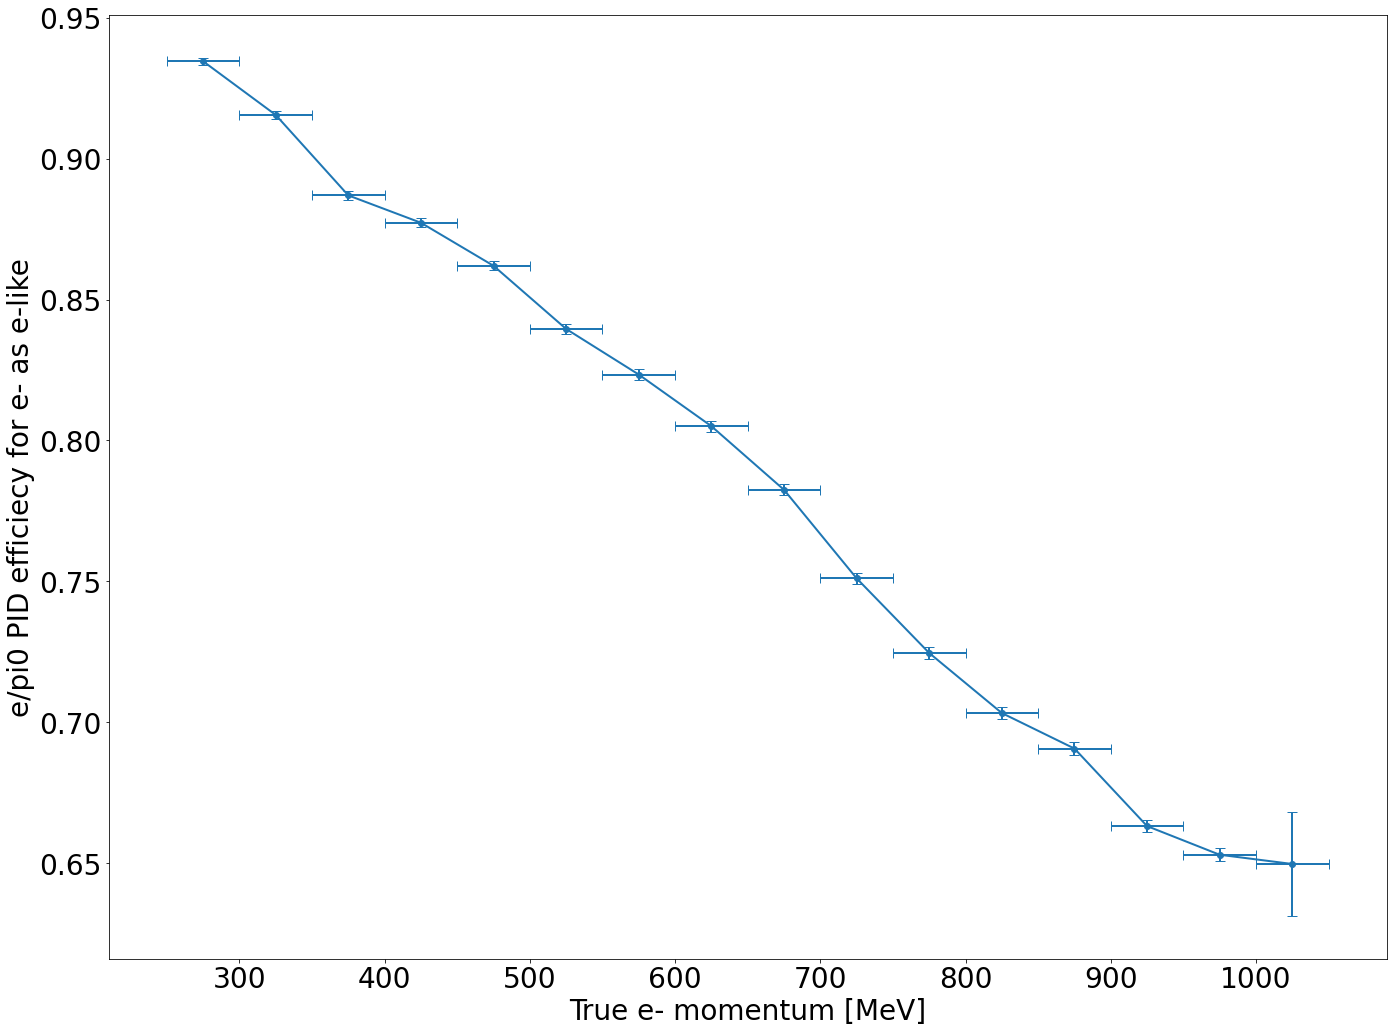

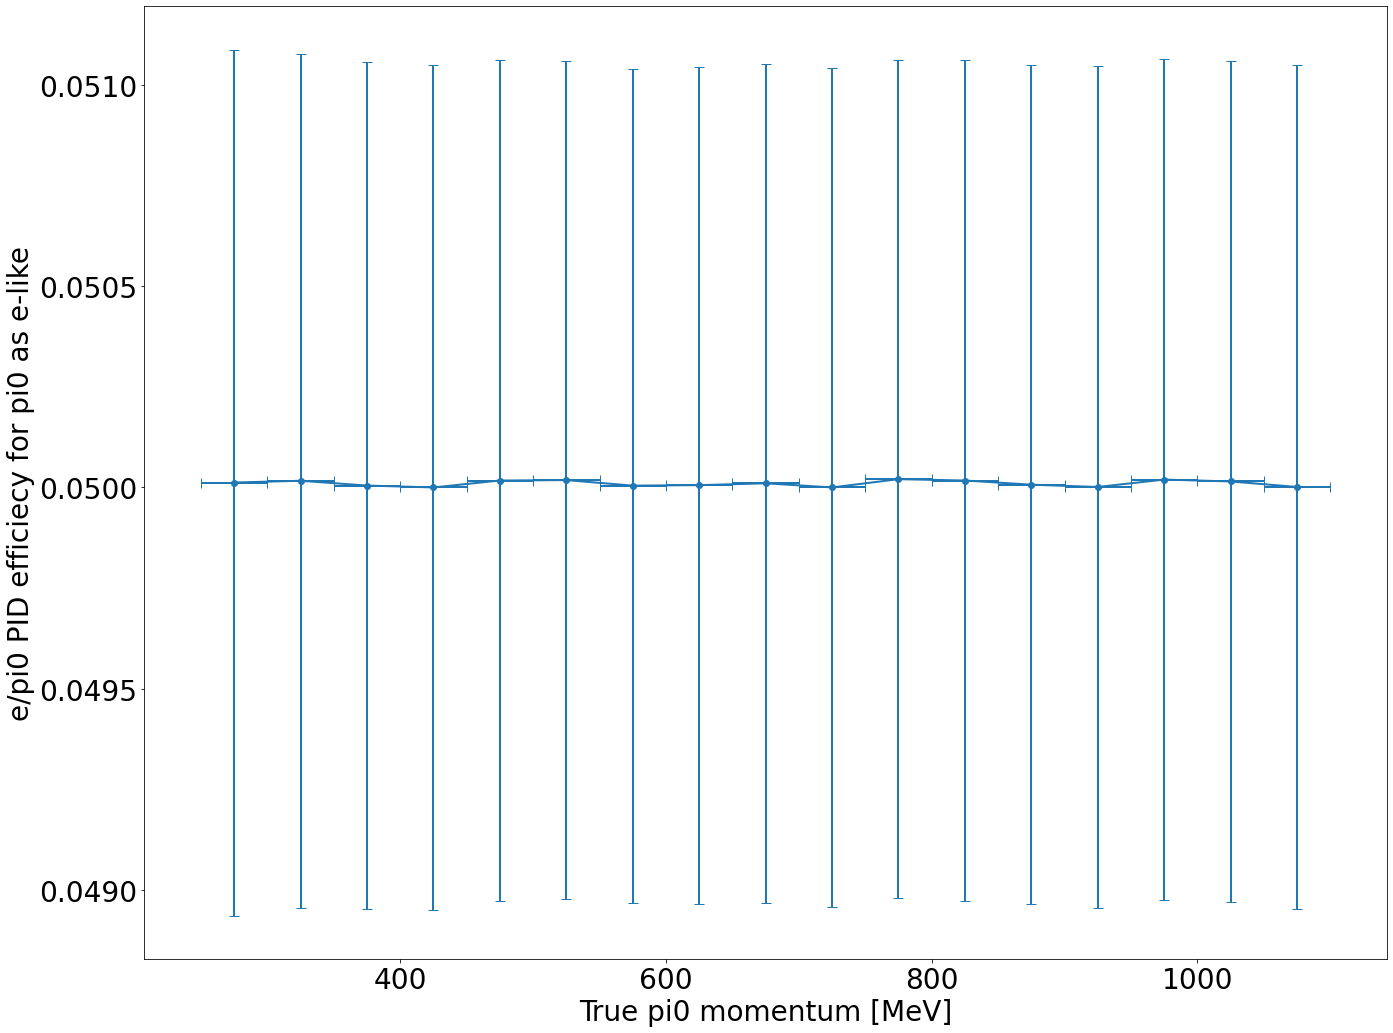

In [12]:
for p in ('e-', 'pi0'):
    plot_binned_res(epi0_eff_binned, plot_bin_centres, p, plot_bin_halfwidths, epi0_eff_binned_err,
                    f"True {p} momentum [MeV]", f"e/pi0 PID efficiecy for {p} as e-like",
                    filename=None)